## Section C: Self-Taught Learning
In this part, you implement self-taught learning for NN using the Autoencoder that is provided in Activity 5.2 and 3-layer NN.

### Question 3: Self Taught Neural Network Learning
>##### 1. Installing and importing libraries and loading the datasets.We will use Task2C_labeled.csv for training the classifier and evaluate on the test dataset.

In [14]:
#installing the h2o and BBmisc library
#install.packages('h2o')
library(h2o)
#install.packages('BBmisc')
library (BBmisc)

In [15]:
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)


 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         53 minutes 37 seconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    2 months and 24 days  
    H2O cluster name:           H2O_started_from_R_Roshi_wjn483 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.38 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 



In [16]:
#to get rid of warnings
options(warn=-1)
# importing all the datasets into respective dataframes.
labeled.frame <-  read.csv("Task2C_labeled.csv")
unlabeled.frame <- read.csv("Task2C_unlabeled.csv")
test.frame <- read.csv("Task2C_test.csv")

# Omiting the Null values in the dataframes
labeled.frame <- labeled.frame[complete.cases(labeled.frame),]
unlabeled.frame <- unlabeled.frame[complete.cases(unlabeled.frame),]
test.frame <- test.frame[complete.cases(test.frame),]

# Converting the Label column into factors
labeled.frame$label <- as.factor(labeled.frame$label)
unlabeled.frame$label <- as.factor(unlabeled.frame$label)
test.frame$label <- as.factor(test.frame$label)

# Except the label columns normalising between 0 and 1. 
labeled.frame <- normalize(labeled.frame, method = "standardize", range = c(0,1), margin = 2L)
unlabeled.frame <- normalize(unlabeled.frame, method = "standardize", range = c(0,1), margin = 2L)
test.frame <- normalize(test.frame, method = "standardize", range = c(0,1), margin = 2L)

# Converting the dataframe to h2oframe
labeled.frame <- as.h2o(labeled.frame)
unlabeled.frame <- as.h2o(unlabeled.frame)
test.frame <- as.h2o(test.frame)

# Converting the label column as a factor
labeled.frame[,1] <- as.factor(labeled.frame$label)
# initiating with NA in labels column
unlabeled.frame[,1] <- NA
# binding the label and unlabeled data and forming a dataframe
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


> ##### 2. Autoencoder : Training the autoencoder with one hidden layer and changing neurons 20,40....500.

In [17]:
# Reconstruction error matrix for errors 
reconstruct.error <- matrix(NA, nrow=27, ncol=2)

# looping through each a sequence of 20,40,60,...,500
for (k in seq(20, 500, 20)){
      
  NN.model <- h2o.deeplearning(    
  x = 2:ncol(train.frame), # select all pixels 
  training_frame = train.frame, # specify the frame (imported file)    
  hidden = c(k), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = TRUE, # is it an autoencoder? No!
  l2 = 0.1 # l2 regularization parameter
)
  #finding the reconstructing error then finding the mean of it and storing 
  error <- mean(as.matrix(h2o.anomaly(NN.model, train.frame, per_feature = FALSE)))  # finding the average 
  reconstruct.error[k/20, 1] <- k
  reconstruct.error[k/20, 2] <- error     # Storing it in the matrix
}
#removing the null values
reconstruct.error <- reconstruct.error[complete.cases(reconstruct.error),]

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

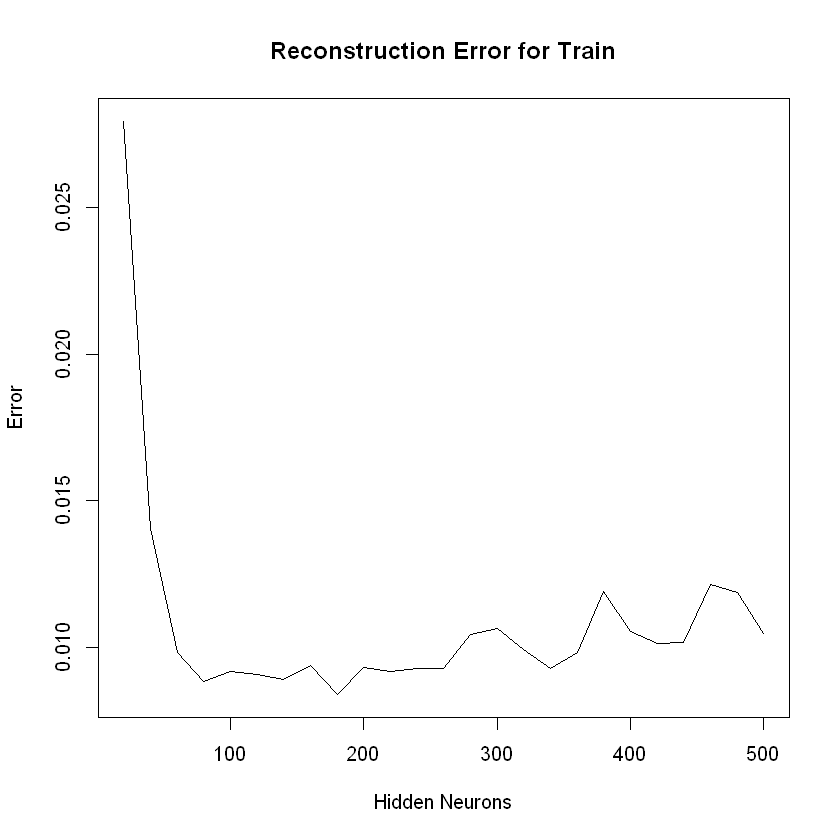

In [18]:
plot(reconstruct.error[,1], reconstruct.error[,2],type = 'l', xlab = 'Hidden Neurons', ylab = 'Error', main = 'Reconstruction Error for Train')

We can see a constant decrease in the reconstruction error starting from 20 and keeps falling untill 220 and after which it keeps increasing.

> ##### 4. Three Layer Neural Network
Now using a 3-layered NN with H2o we have to build a network with 100 hidden neurons. It is told that we have to set autoencoder to False since it is Normal NN classifier.  

In [19]:
# 3 Layered NN
NN.model_classifier <- h2o.deeplearning(    
    x = 2:ncol(labeled.frame), # select all pixels + extra features
    y = 1,
    training_frame = labeled.frame, # specify the frame (imported file)    
    hidden = c(100), # number of layers and their units
    epochs = 50, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = FALSE, # is it an autoencoder? No!
    l2 = 0.1    # L2 regularization parameter
    )

  |======================================================================| 100%


In [20]:
# Error rate to calculate error from predicted and true labels
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}
test.predict <- h2o.predict(NN.model_classifier, test.frame)$predict
cat("The recorded test error is : ", error.rate(test.frame$label, test.predict))

  |======================================================================| 100%
The recorded test error is :  0.46

>##### 5. Augmented Self-taught Network.

In [21]:
# Creating a matrix to store the misclassification error 
missclass <- matrix(NA, nrow=27, ncol=2)
# Increasing hidden layer units from 20 to 500 by step of 20
for (k in seq(20, 500, 20)){      
    NN.model <- h2o.deeplearning(    
      x = 2:ncol(train.frame), # select all pixels + extra features
      training_frame = train.frame, # specify the frame (imported file)    
      hidden = c(k), # number of layers and their units
      epochs = 50, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = TRUE, # is it an autoencoder? No!
      l2 = 0.1
    )
    # Extracting the features
    features <- as.h2o(as.matrix(h2o.deepfeatures(NN.model, train.frame, layer=1)))   
    features <- project[1:nrow(labeled.frame),]      
    labeled.frame_new <- h2o.cbind(labeled.frame, features)
    NN.model_classifier <- h2o.deeplearning(    
        x = 2:ncol(labeled.frame_new), # select all pixels + extra features
        y = 1,
        training_frame = labeled.frame_new, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = FALSE, # is it an autoencoder? No!
        l2 = 0.1
    )
    error <- error.rate(test.frame$label, h2o.predict(NN.model_classifier, test.frame)$predict)
    
    missclass[k/20,1] <- k
    missclass[k/20,2] <- error    
}
missclass <- missclass[complete.cases(missclass),]

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

20,0.594
40,0.640
60,0.574
80,0.479
100,0.527
120,0.463


>##### 6. Misclassification Error plot

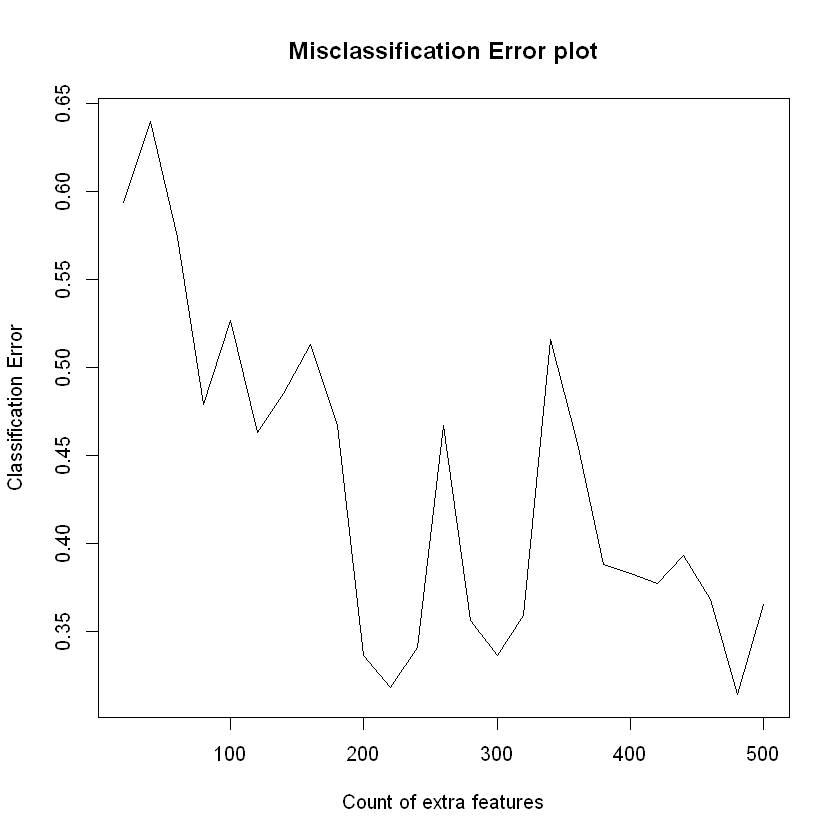

In [22]:
plot(missclass[,1],missclass[,2], type = 'l',  xlab = 'Count of extra features', ylab = 'Classification Error', main = 'Misclassification Error plot')

> ##### 7. Optimum number of units in the hidden layer of the neural network 


If we look closely, we can see that 220 is the optimum number of neurons in both the plots, it is the point where the reconstruction and misclassification error is the lowest and there after the error keeps increasing, hence we can rightly conclude that 220 neurons would be optimum number.

> ##### 8. Comparing the reconstruction error plot and the misclassification error plot.

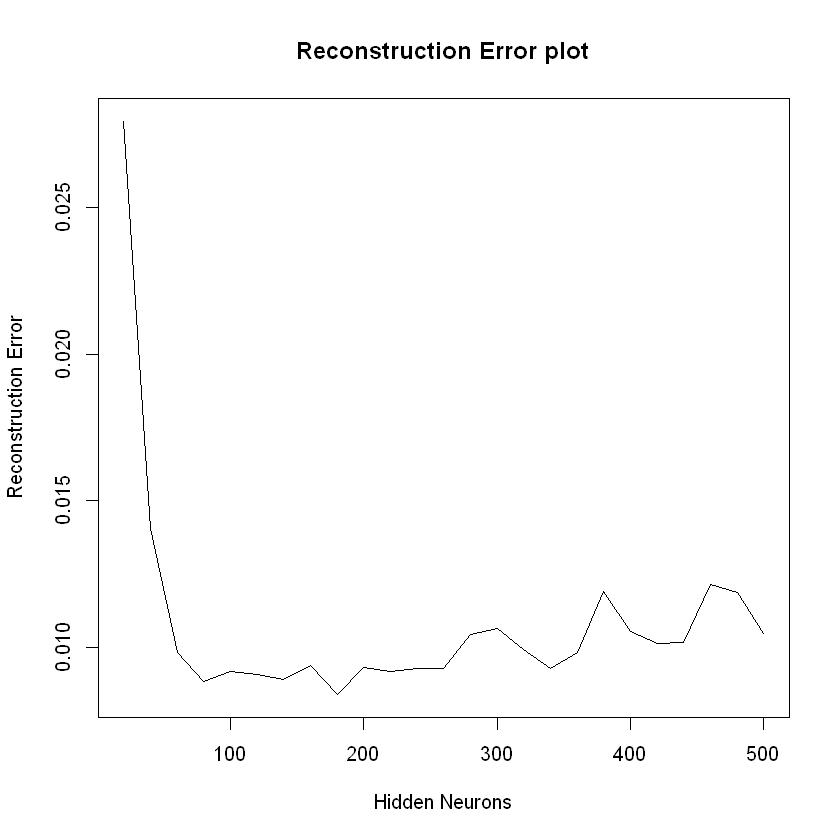

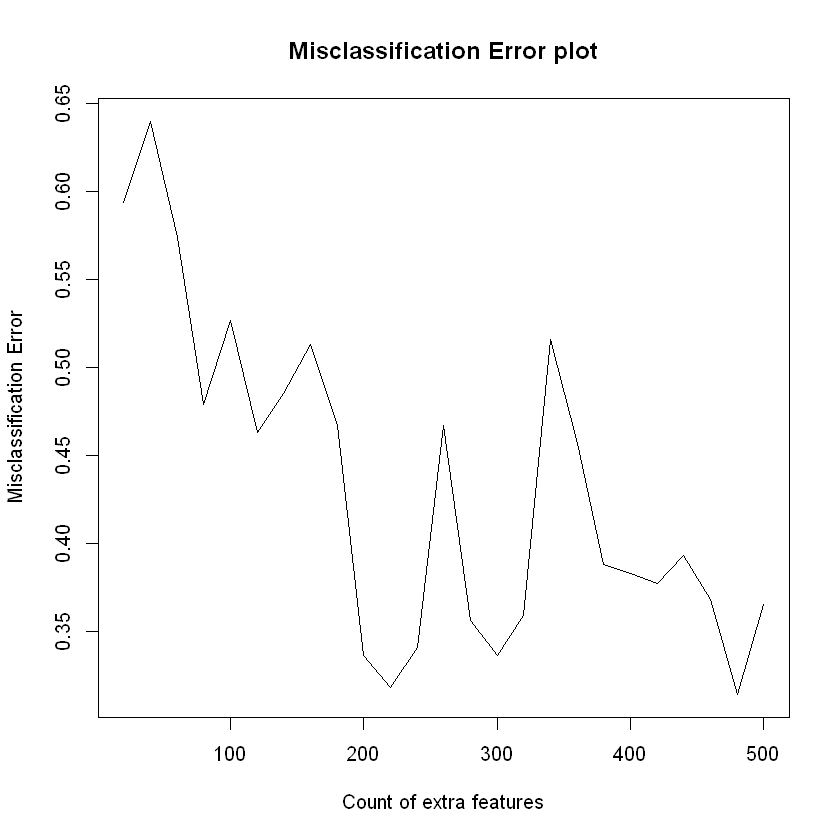

In [23]:
plot(reconstruct.error[,1], reconstruct.error[,2],type = 'l', xlab = 'Hidden Neurons', ylab = 'Reconstruction Error', main = 'Reconstruction Error plot')
plot(missclass[,1],missclass[,2], type = 'l',  xlab = 'Count of extra features', ylab = 'Misclassification Error', main = 'Misclassification Error plot')

[1] 1.800000e+02 8.410861e-03

Looking at the minimum error at 180 neurons, we can call this for the optimum error, but to find some relation with the misclassification error plot, we can take 220 as the optimum.

In [27]:
# The optimum number(s) of units in the middle layer of the autoencoder in terms of the  misclassification errors.
missclass[which(missclass[,2]==min(missclass[,2])),]

[1] 480.000   0.314

The above quoted number of neurons cannot be a optimum number of neurons, since as we can see in the plot, that there is another minimum at 220 which is second lowest but uses, less than half of the neurons from the prior case.

In our reconstruction error plot, we can see that the error highly drops for 20 hidden neurons and there after keeps falling,to a certain point i.e 180 , further it attains some uniformity and then increases from 220, giving us a optimum number. Whereas in our second plot that is misclassification error, we see high variance at the extremes giving high unstability and cannot be determined, they might be due to high deviation or variance in the data, this makes the misclassification plot unpredictable, but if we look closely after the 220 neurons, we never see any decrease in the error.
    The relationship apart from 220 neurons, we cannot see any consistent relationship between the two error plots.The ways to better relationship between these plots can be good wrangling, standardization, and better features. Another approach to achieve this could be by changing the h2o parameters and testing parameter like epochs and activation function, etc.